# Exploratory Data Analysis for Assesing Pathogenicity Problem  - Custom Parsing

This notebook was created  to showcase EDA for assesing pathogenicity problem. This notebook utilizes custom parsing implemented according to expert's specifications.

## Imports

In [1]:
from utils.EDA_utils import *
from utils.utils import get_dataset

In [2]:
df = get_dataset("data/", samples=["EE_015", "EE_050", "EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [3]:
df.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,chr1,15820,G,T,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
1,chr1,17385,G,A,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2,chr1,17697,G,C,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
3,chr1,133129,G,A,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
4,chr1,183629,G,A,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN


In [4]:
df["ACMG_class"]

0         Uncertain%40Significance
1         Uncertain%40Significance
2                           Benign
3         Uncertain%40Significance
4                           Benign
                    ...           
444439    Uncertain%40Significance
444440    Uncertain%40Significance
444441    Uncertain%40Significance
444442    Uncertain%40Significance
444443    Uncertain%40Significance
Name: ACMG_class, Length: 444444, dtype: object

The target attribute is ACMG_class. The cardinality of this attribute is 5 with the number of occurences of each example being written below. As can be seen some mutations are much rarer than others, so techniques to fight against problems related to minority class will need to be employed.

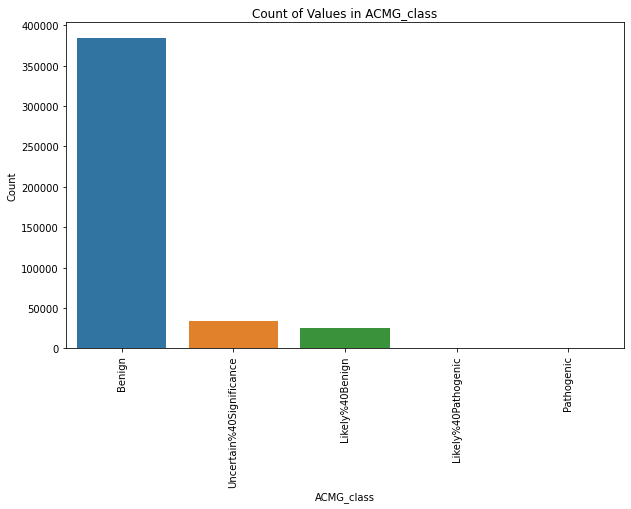

In [5]:
get_target_plot(df, "ACMG_class")

## Nans Section

Exploring the Nans present in the dataset - visualizations and summary

Counting Nans

In [6]:
nan_count_per_column = df.isna().sum()
nan_count_per_column[nan_count_per_column>0]

AS_SB_TABLE               140174
ECNT                      140174
GERMQ                     140174
MBQ                       140174
MFRL                      140174
MPOS                      140174
POPAF                     140174
RPA                       140174
RU                        140174
STR                       140174
STRQ                      140174
TLOD                      140174
cosmicFathMMPrediction    140174
cosmicFathMMScore         140174
SYMBOL                     42674
Feature_type               12585
Feature                    12585
BIOTYPE                    12598
EXON                      302853
INTRON                    253015
HGVSc                     111466
Amino_acids               393016
Codons                    393014
Existing_variation         11545
DISTANCE                  347708
STRAND                     14683
SYMBOL_SOURCE              42674
CANONICAL                 159822
MANE_SELECT               244963
MANE_PLUS_CLINICAL        444035
gnomADe_AF

Below Visualization is meant to provide information about the number of NaNs in chosen columns. Basically, we choose every column that has more than 100 000 Nans, meaning around 1/4th. If such a high numbers of Nans is present, me may consider dropping the column or doing something else with it. As such, We ended up visualizing all attributes for each number of Nans is greater than 100 000 to decide what to do with these columns farther. Some columns are all Nans or close to all Nans, as such dropping this data may be necessary.

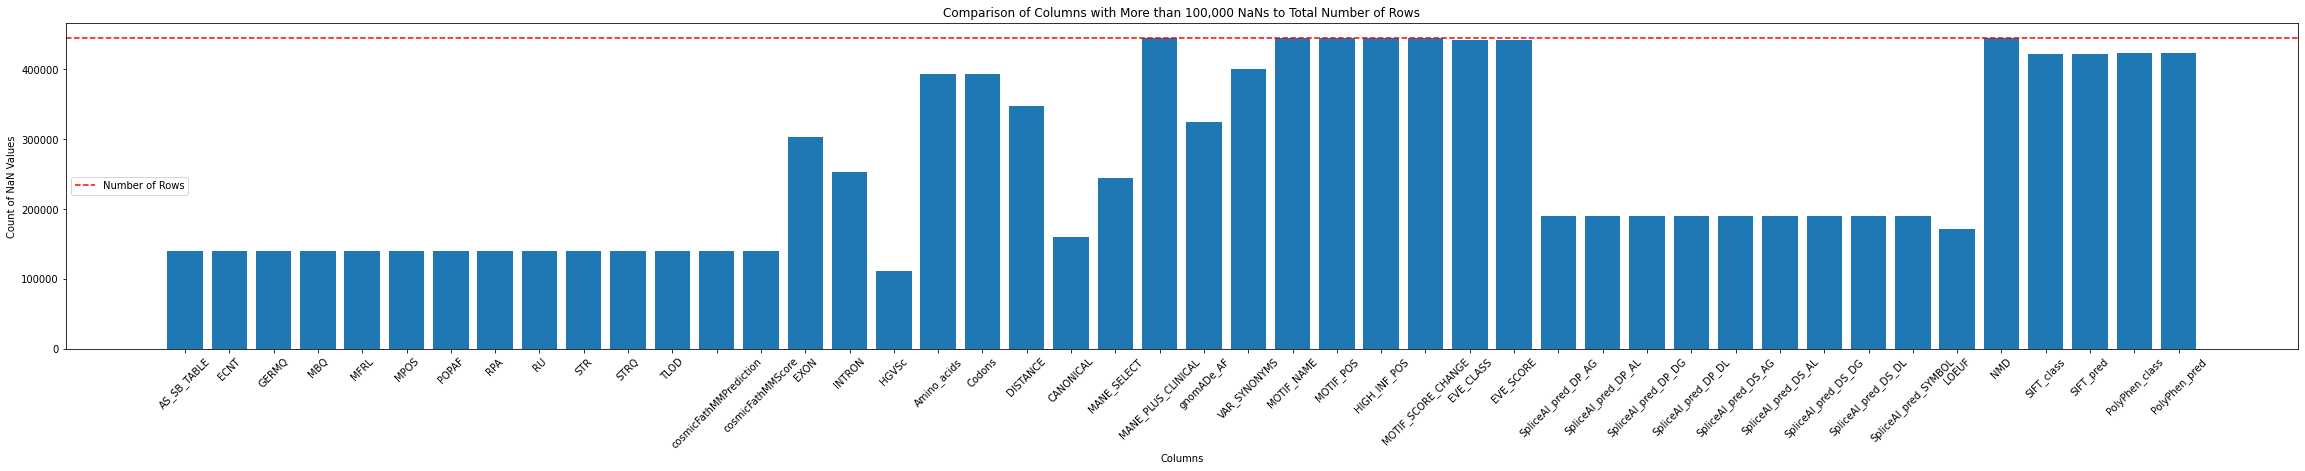

In [7]:
get_nans_plot(df, nan_threshold = 100000)

Summary of Columns

In [8]:
pd.set_option('display.max_rows', 118)
nans_df = inspect_columns(df)
nans_df

,unique,cardinality,with_null,null_count,null_pct,1st_row,random_row,last_row,dtype
#CHROM,False,76,False,0,0.00,chr1,chr1,chrY,object
POS,False,275143,False,0,0.00,15820,12861532,56856670,int64
REF,False,3555,False,0,0.00,G,C,G,object
ALT,False,2881,False,0,0.00,T,T,T,object
QUAL,False,9986,False,0,0.00,.,.,467.77,object
FILTER_map_qual,False,2,False,0,0.00,0,1,0,int64
FILTER_clustered_events,False,2,False,0,0.00,0,0,0,int64
FILTER_weak_evidence,False,2,False,0,0.00,0,0,0,int64
FILTER_slippage,False,2,False,0,0.00,0,0,0,int64
FILTER_strand_bias,False,2,False,0,0.00,0,0,0,int64


Showing Only Nan Columns

In [9]:
nans_df = nans_df[nans_df['null_count'] > 0]
nans_df = nans_df.drop(columns = ["unique", "last_row", "1st_row", "with_null", "random_row"])

nans_df

,cardinality,null_count,null_pct,dtype
AS_SB_TABLE,86334,140174,31.54,object
ECNT,44,140174,31.54,float64
GERMQ,93,140174,31.54,float64
MBQ,26,140174,31.54,float64
MFRL,815,140174,31.54,float64
MPOS,51,140174,31.54,float64
POPAF,1,140174,31.54,float64
RPA,28,140174,31.54,float64
RU,1307,140174,31.54,object
STR,2,140174,31.54,float64


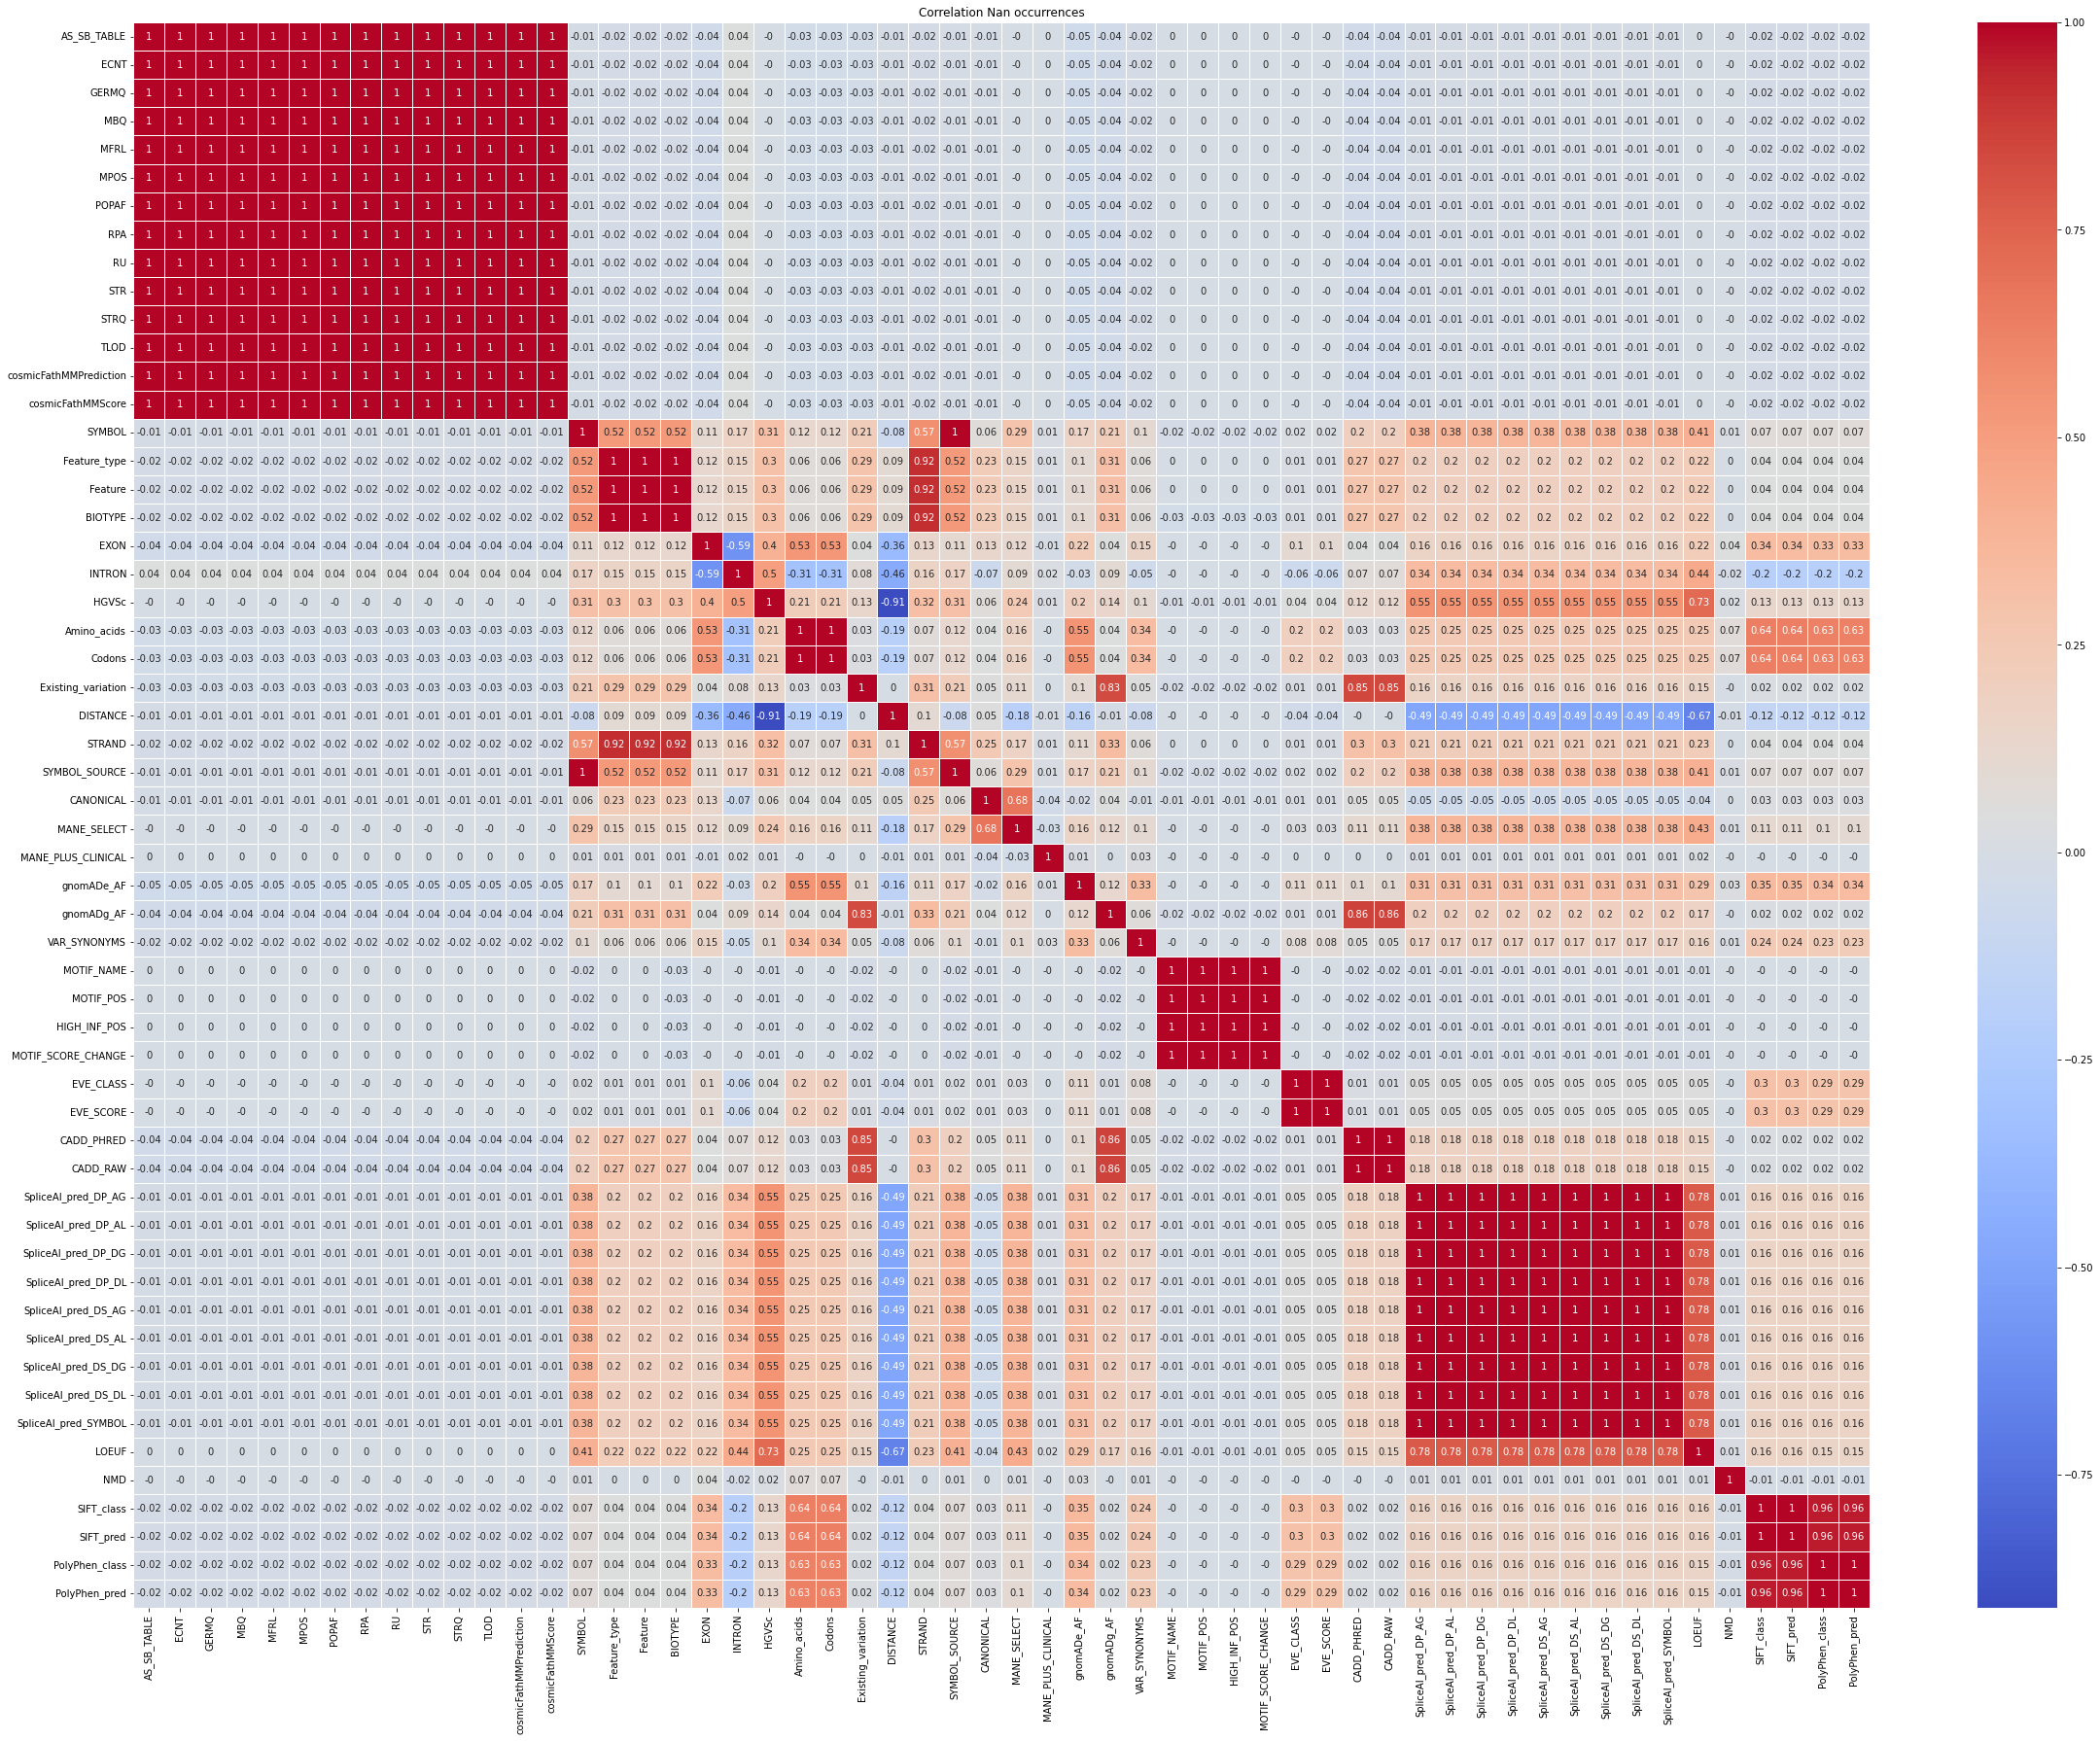

In [10]:
plot_corr_heatmap_nans(df)

Correlation of Nans with ACMG_class 

c:\Users\creep\Desktop\studia\sem5\problem classes\pathogenicity-assessment\utils\EDA_utils.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_nan[target] = df_with_nan[target].astype('category').cat.codes


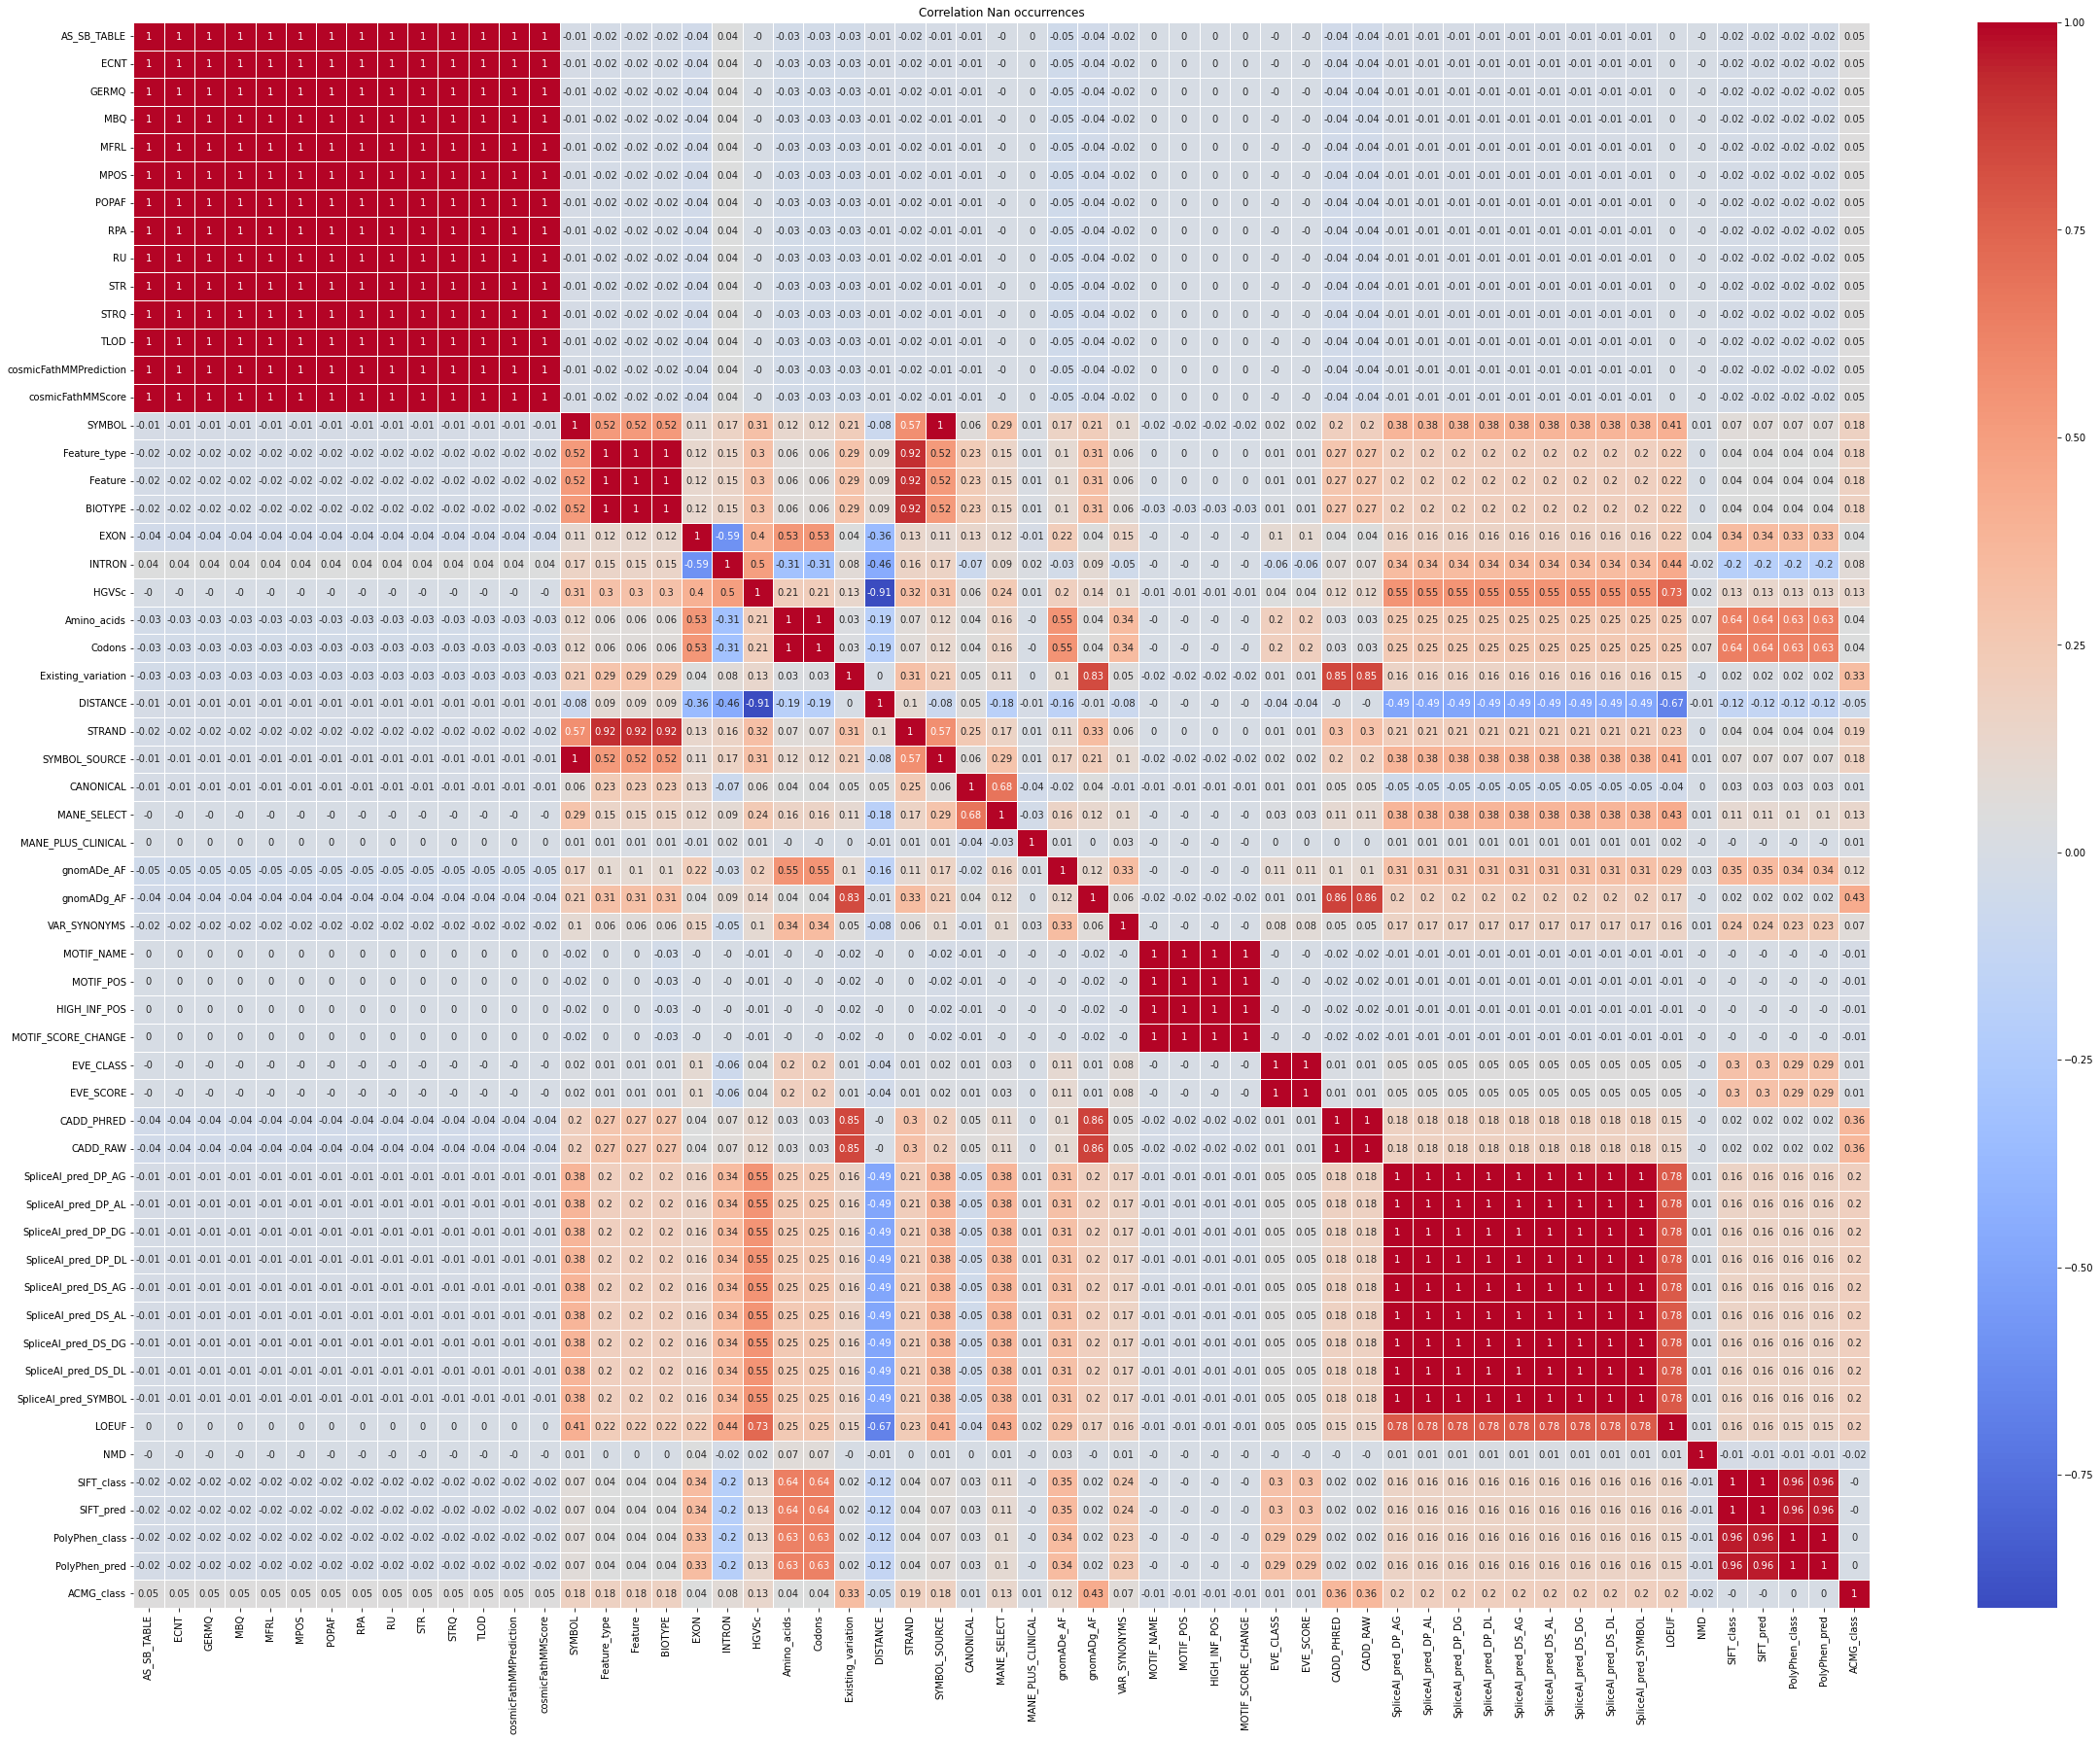

In [11]:
plot_corr_heatmap_nans_target(df, target="ACMG_class")

Highest Correlations of Nans to ACMG_class

In [12]:
get_nan_corr_treshold(df, target="ACMG_class", correlation_threshold = 0.15)

c:\Users\creep\Desktop\studia\sem5\problem classes\pathogenicity-assessment\utils\EDA_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_nan[target] = df_with_nan[target].astype('category').cat.codes


Index(['SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'Existing_variation',
       'STRAND', 'SYMBOL_SOURCE', 'gnomADg_AF', 'CADD_PHRED', 'CADD_RAW',
       'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG',
       'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', 'SpliceAI_pred_SYMBOL',
       'LOEUF', 'ACMG_class'],
      dtype='object')

## Datatype Visualizations

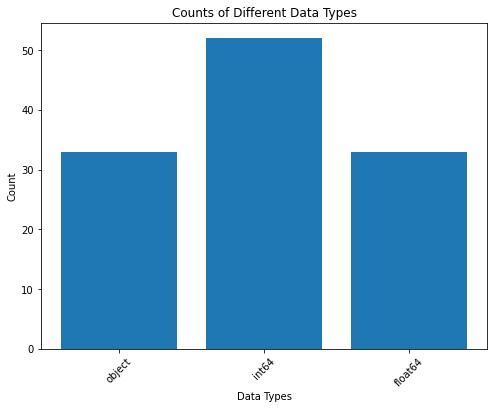

In [13]:
plot_dtypes(df)

## Proposed Preprocessing

This section includes a function performing the preprocessing steps. This function should be copied and pasted into the utils section as well for the sake of simplicity and re-usibility in the model section.

### Showing different proposed preprocessing schemes below:

In [14]:
preprocessed_df1 = preprocess(df)
preprocessed_df1.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,chr1,15820,G,T,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,chr1,17385,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,chr1,17697,G,C,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,chr1,133129,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,chr1,183629,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [15]:
preprocessed_df2 = preprocess(df, fill_median=True)
preprocessed_df2.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,chr1,15820,G,T,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,chr1,17385,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,chr1,17697,G,C,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,chr1,133129,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,chr1,183629,G,A,.,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [16]:
preprocessed_df3 = preprocess(df, one_hot_nans = False)
preprocessed_df3.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,chr1,15820,G,T,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
1,chr1,17385,G,A,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
2,chr1,17697,G,C,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
3,chr1,133129,G,A,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0
4,chr1,183629,G,A,.,0,0,0,0,0,...,No Value,-0.97,No Value,0,0,0,No Value,-1.0,No Value,-1.0


## Encoding Objects to Categories

Used Functions and Example Use

In [17]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"

In [18]:
temp_df,encoders,target_mapping = encode(preprocessed_df1, target_column, custom_mapping)
temp_df.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [19]:
get_mapping(encoders, "cosmicFathMMPrediction")

cosmicFathMMPrediction mapping: {'0': 0, 'Benign': 1, 'Likely%40Benign': 2, 'Likely%40Pathogenic': 3, 'No Value': 4, 'Pathogenic': 5}


In [20]:
target_mapping

{'Benign': 0,
 'Likely%40Benign': 1,
 'Uncertain%40Significance': 2,
 'Likely%40Pathogenic': 3,
 'Pathogenic': 4}

Using on defined dataframes

In [21]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"

In [51]:
encoded_df1, encoders1, target_mapping1 = encode(preprocessed_df1, target_column, custom_mapping)
encoded_df1.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [54]:
encoded_df2, encoders2, target_mapping2 = encode(preprocessed_df2, target_column, custom_mapping)
encoded_df2.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [55]:
encoded_df3, encoders3, target_mapping3 = encode(preprocessed_df3, target_column, custom_mapping)
encoded_df3.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_map_qual,FILTER_clustered_events,FILTER_weak_evidence,FILTER_slippage,FILTER_strand_bias,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,0,15820,1773,2117,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
1,0,17385,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
2,0,17697,1773,721,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
3,0,133129,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
4,0,183629,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0


## Data type counts

Dataframe 1

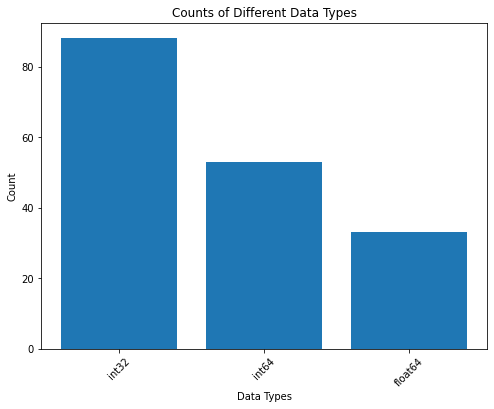

In [25]:
plot_dtypes(encoded_df1)

Dataframe 2

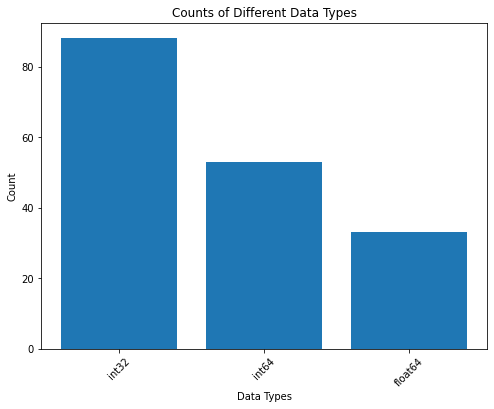

In [26]:
plot_dtypes(encoded_df2)

Dataframe 3

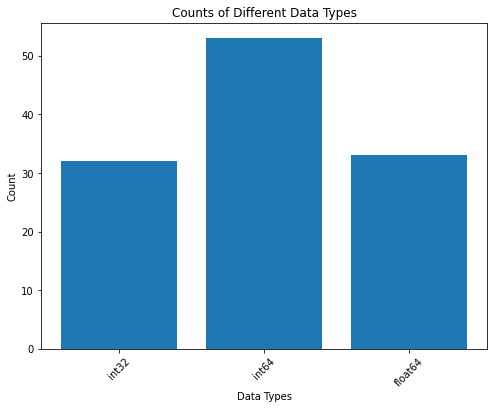

In [27]:
plot_dtypes(encoded_df3)

## Heatmaps of Correlations

Dataframe 1

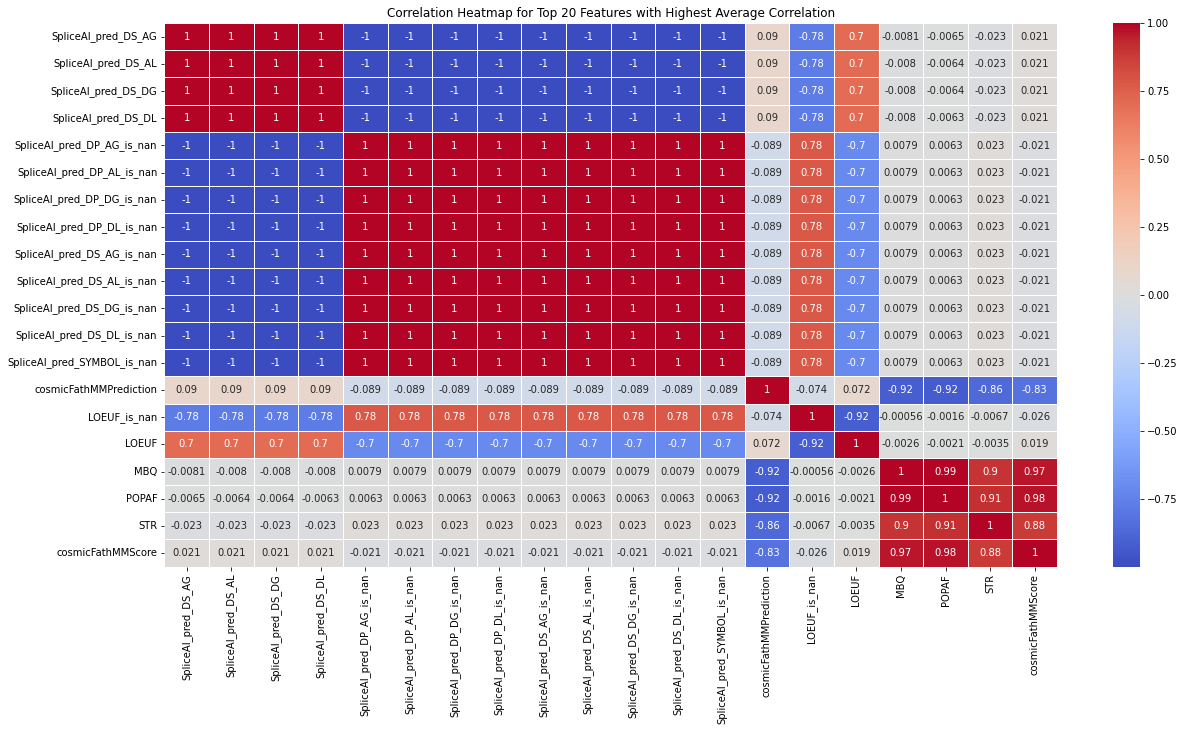

In [28]:
get_corr_heatmap(encoded_df1)

Datframe 2

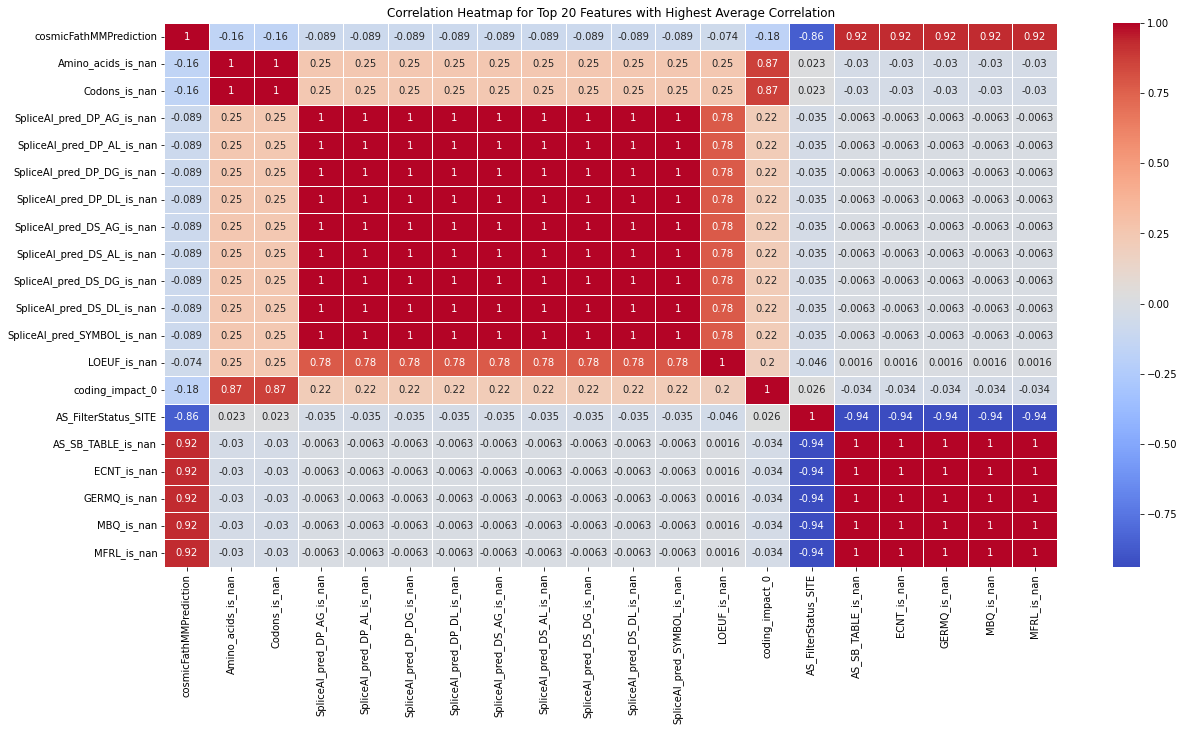

In [29]:
get_corr_heatmap(encoded_df2)

Dataframe 3

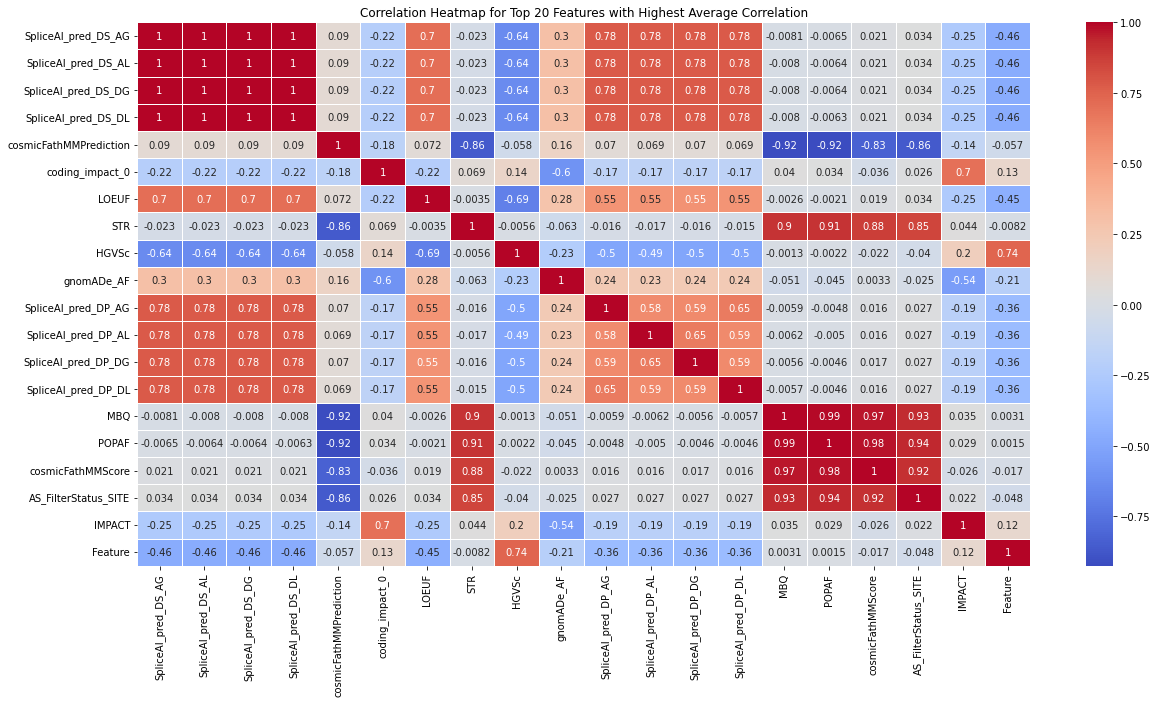

In [30]:
get_corr_heatmap(encoded_df3)

## Correlation and Mutual Information for ACMG_class

### Correlation

Dataframe 1

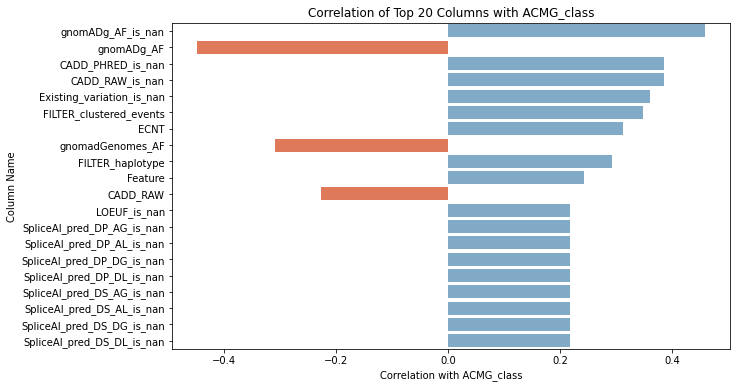

In [31]:
target_col = "ACMG_class"
get_corr_target(encoded_df1, target_col)

Dataframe 2

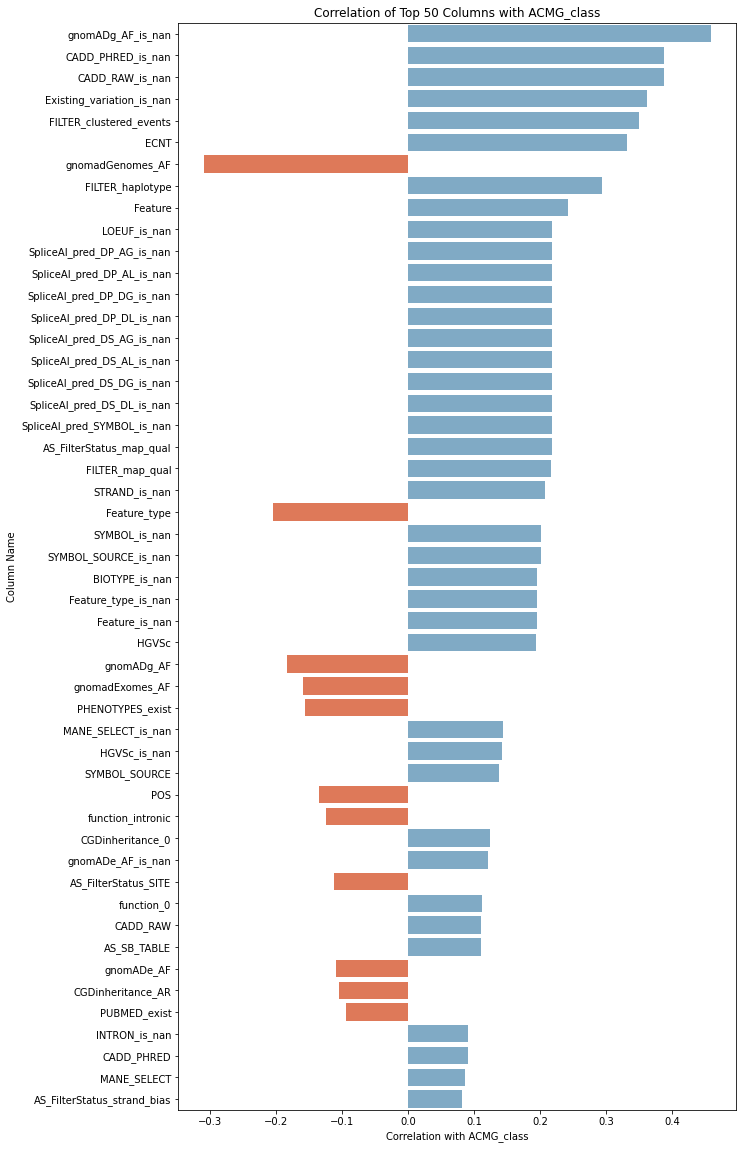

In [32]:
get_corr_target(encoded_df2, target_col, k=50, plot_size=(10, 20))

Dataframe 3

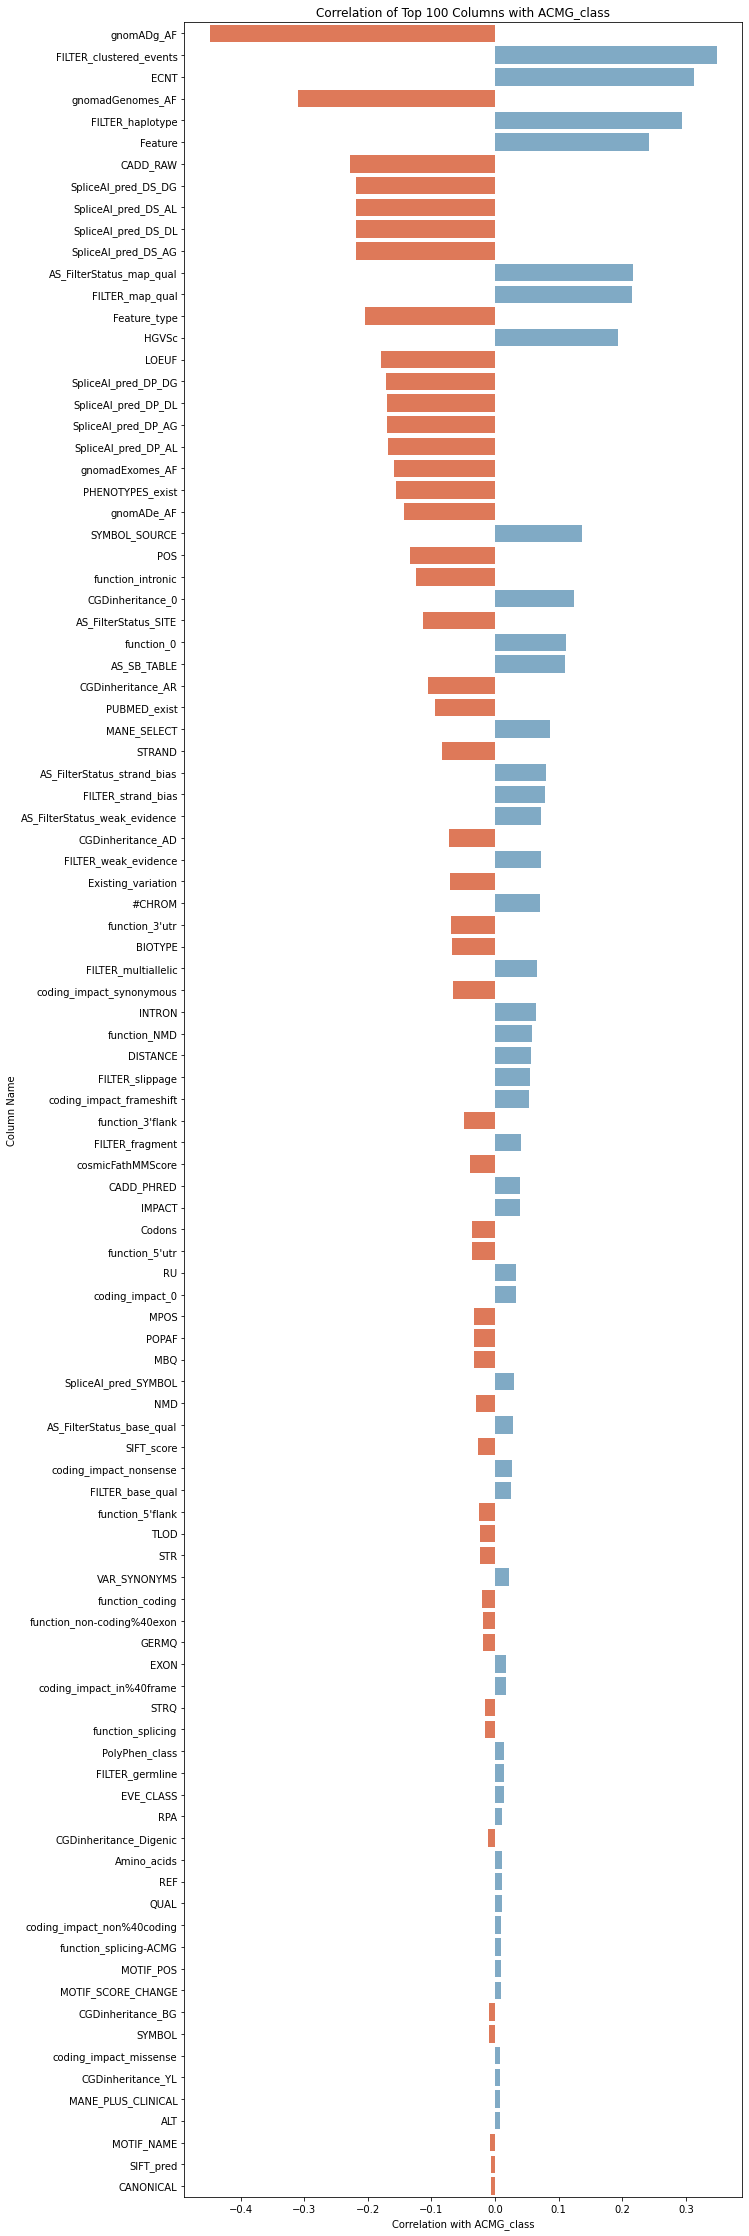

In [33]:
get_corr_target(encoded_df3, target_col, k=100, plot_size=(10, 40))

### Mutual Information

Dataframe 1

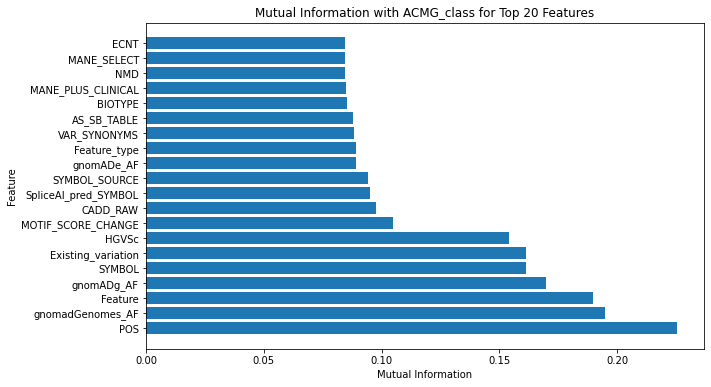

In [34]:
target_col = "ACMG_class"
get_mutual_info_plot(encoded_df1, target_col)

Datframe 2

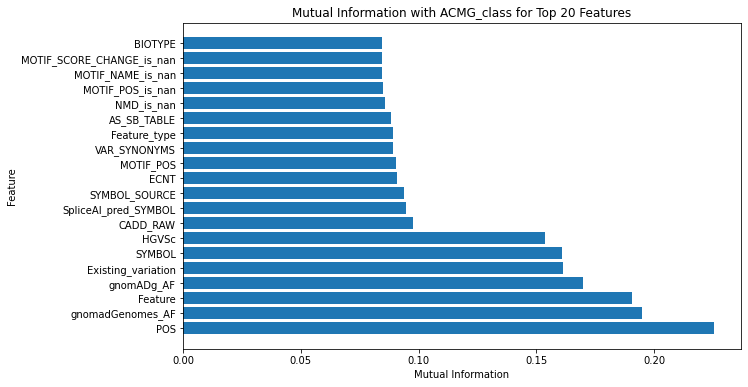

In [35]:
target_col = "ACMG_class"
get_mutual_info_plot(encoded_df2, target_col)

Datframe 3

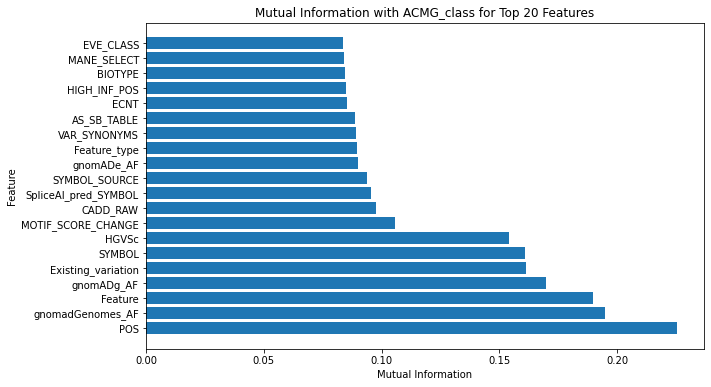

In [36]:
target_col = "ACMG_class"
get_mutual_info_plot(encoded_df3, target_col)

In [56]:
from sklearn.ensemble import RandomForestClassifier
target_col='ACMG_class'
encoded_df1=encoded_df1.drop(target_col, axis=1)
encoded_df2=encoded_df2.drop(target_col, axis=1)
encoded_df3=encoded_df3.drop(target_col, axis=1)
rf_classifier1 = RandomForestClassifier(n_estimators=100, max_depth=4)
rf_classifier1.fit(encoded_df1, df[target_col])
rf_classifier2 = RandomForestClassifier(n_estimators=100, max_depth=4)
rf_classifier2.fit(encoded_df2, df[target_col])
rf_classifier3 = RandomForestClassifier(n_estimators=100, max_depth=4)
rf_classifier3.fit(encoded_df3,df[target_col])


RandomForestClassifier(max_depth=4)

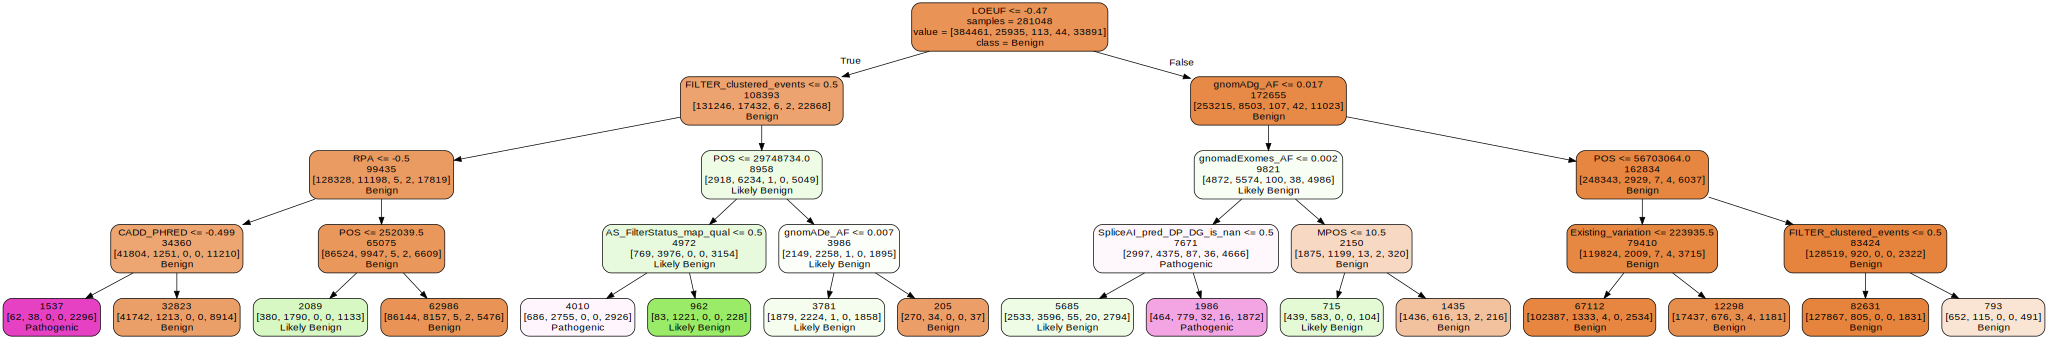

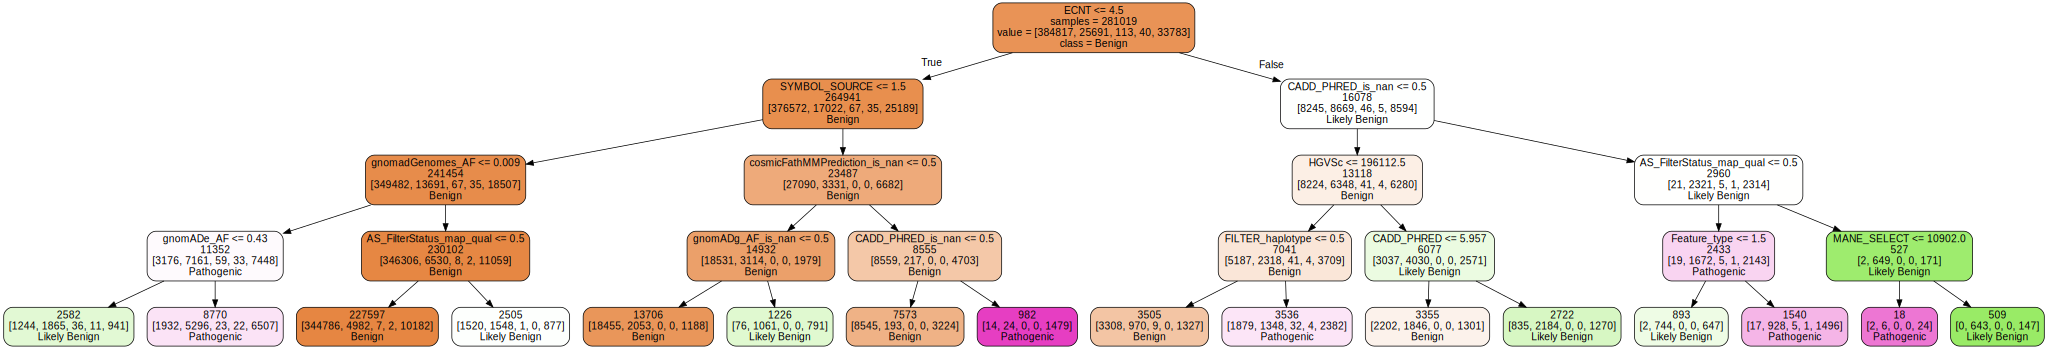

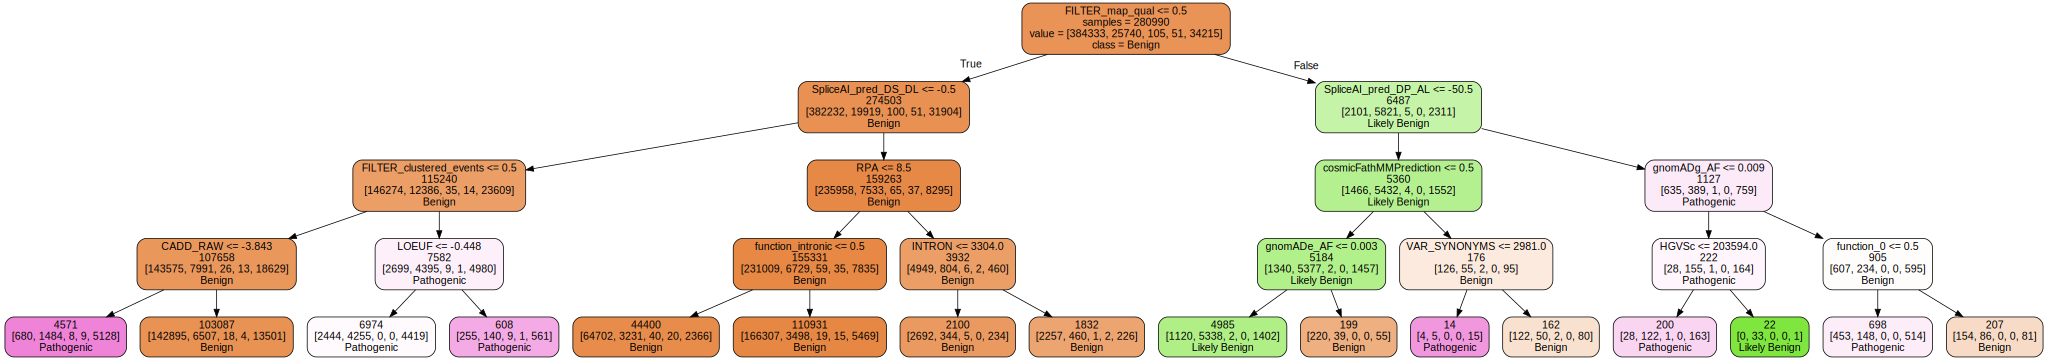

In [70]:
from sklearn.tree import export_graphviz
import graphviz
dfs=[encoded_df1,encoded_df2, encoded_df3]
trees=[rf_classifier1.estimators_[0].set_params(max_depth=3),rf_classifier2.estimators_[0].set_params(max_depth=3),rf_classifier3.estimators_[0].set_params(max_depth=3)]
for x in range(len(trees)):
    
    dot_data = export_graphviz(trees[x], out_file=None, 
                            feature_names=dfs[x].columns,
                            class_names=['Benign','Likely Benign','Uncertain Significance','Likely Pathogenic','Pathogenic'],
                            label='root',
                            impurity=False,
                            node_ids=False,
                            proportion=False,
                            filled=True, rounded=True, special_characters=False)

    graph = graphviz.Source(dot_data)
    display(graph)
